# Project 2: Titanic Dataset
Author:        Peter Eisenschmidt
Creation Date: December 7, 2016

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Questions
The main question is whether the data can reveal factors that may have contributed to surviving. For example, was the code of conduct "women and children first" applied in case of the RMS Titanic? Or was it "survival of the fittest", i.e. young men?

What role did social status play? Was a 1st class passenger more likely to survive than a 3rd class passenger?

# Load Dataset and Data Wrangling
The purpose of this section is to load the csv file and to have a first check of the data. Then new columns are added which will be needed in the later analysis.

In [2]:
# import the dataset
titanic_data = pd.read_csv('titanic-data.csv')

The first step is to check whether all columns are filled with values or if there are values missing. This can be done with the `count()` function of the Pandas dataframe.

In [3]:
titanic_data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Most columns contain 891 values and hence do not have missing values. However, it can be seen that 'Age' only has 714 values, the rest are NaN. 

For this project it has been decided to fill the missing age values with the median value for each class separately for men and women. This is done by grouping the data by sex and class and calculating the median value. A function `get_median_age` is used to assign the correct value to each row and to store it in a temporary dataframe. This dataframe is then used with the pandas `fillna()` function to replace the missing values.

Furthermore, a lot of values for 'Cabin' are missing, but this information is not really critical for the analysis. Lastly, the port of embarkation is missing for 2 people. As for the cabin data, this is not critical for the analysis.

In [4]:
# Fill missing age values using median values
group_by_sex_class = titanic_data.groupby(['Sex','Pclass'])
grouped_median = group_by_sex_class.median()

sex_list = ['male', 'female']
class_list = [1, 2, 3]

def get_median_age(row):
    '''
    This function determines the median age for men and women and for each class in each row.
    '''
    sex = row.Sex
    class_value = row.Pclass
    return float(grouped_median.Age.loc[(grouped_median.index.get_level_values('Sex')==sex) & 
                                      (grouped_median.index.get_level_values('Pclass')==class_value)])

# temporary dataframe containing the median age for each row
median_age = titanic_data.apply(lambda row: get_median_age(row),axis=1)

titanic_data.Age.fillna(median_age,inplace=True)

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The next step is to create two new columns based on the existing columns. The first one is the introduction of the 'survived' class. Depending on whether the value of the 'Survived' column is 0 (=perished) or 1 (=survived), the new column will contain the strings 'perished' or 'survived'. The reason is that this new column can directly be used for labelling data and it will immediately be possible to understand the meaning without having to check the meaning of 0 or 1.

The second column that is introduced is to distinguish between adults and children. This will be used to check whether "women and children first" was really applied in the case of the RMS Titanic. The distinction is based on the age. It is understood that this is arbitrary, as a 16-year old boy may well have been treated like an adult during the evacuation of the Titanic, whereas legally (at least under today's legislation) he is still a child. 

For the purpose of this project, the threshold was set to 14 years.

In [5]:
# Create new column based on the values of the 'Survived' column with the status 'perished' and 'survived'. 
# This makes the analysis more readable
titanic_data['Survived_class'] = titanic_data['Survived'].map({0: 'perished', 1: 'survived'})

# Create a new column to have a class 'adult' or 'child', depending on the age
titanic_data['Adult'] = titanic_data['Age'].apply(lambda x: 'child' if x < 14 else 'adult')

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_class,Adult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,perished,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,survived,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,survived,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,survived,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,perished,adult


Finally, using the pandas `describe` function, the values are checked to see if there are any non-realistic values, outliers, etc.

In [6]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.112424,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.304424,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.500000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Exploration
The first step is to have a look at the repartition of the passengers: by class, by sex etc. This is also combined to check the number of men and women per class. This is important with regards to the question whether class and/or sex had an influence on the chance of surviving.

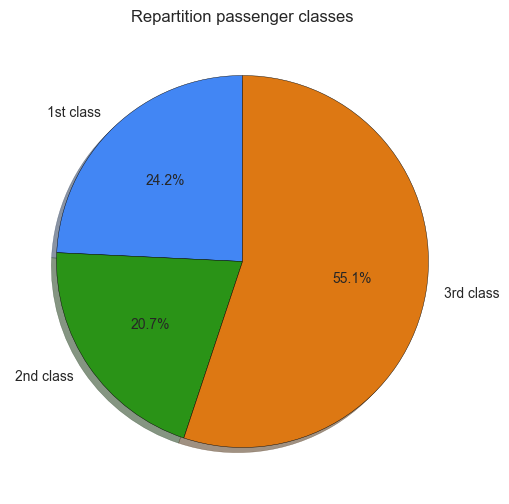

In [7]:
# create array that contains the number of 1st, 2nd, and 3rd class passengers
class_repartition = np.array([len(titanic_data[titanic_data.Pclass==1]),len(titanic_data[titanic_data.Pclass==2])
                     ,len(titanic_data[titanic_data.Pclass==3])])
labels = ['1st class', '2nd class', '3rd class']
colors = ['#4286f4', '#2a9317', '#dd7813']

# create pie chart
plt.figure(3,figsize=(6,6))
plt.pie(class_repartition,labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90);
plt.title('Repartition passenger classes');

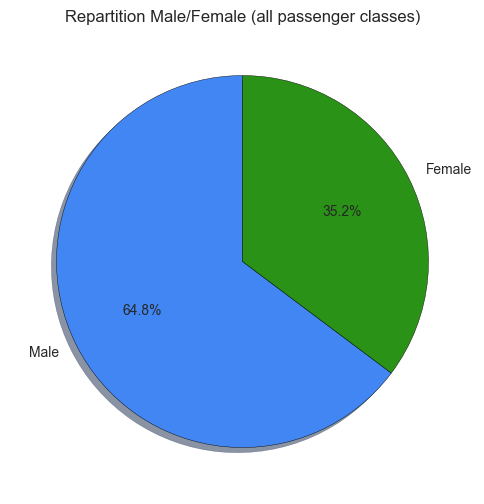

In [8]:
# create array that contains the number of men and women
sex_repartition = np.array([len(titanic_data[titanic_data.Sex=='male']),len(titanic_data[titanic_data.Sex=='female'])])

labels = ['Male', 'Female']
colors = ['#4286f4', '#2a9317']

plt.figure(3,figsize=(6,6))
plt.pie(sex_repartition,labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90);
plt.title('Repartition Male/Female (all passenger classes)');

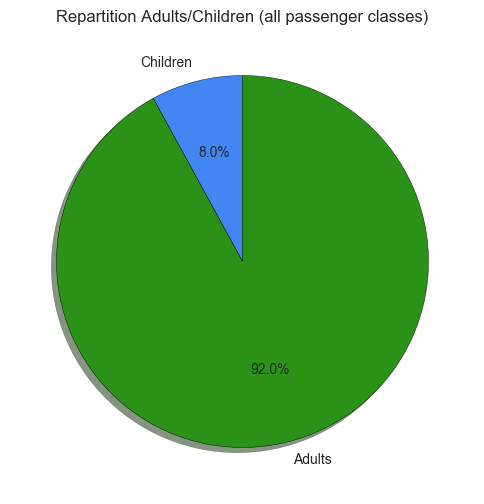

In [9]:
# create array that contains the number of children and adults
child_repartition = np.array([len(titanic_data[titanic_data.Adult=='child']),len(titanic_data[titanic_data.Adult=='adult'])])

labels = ['Children', 'Adults']
colors = ['#4286f4', '#2a9317']

plt.figure(3,figsize=(6,6))
plt.pie(child_repartition,labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90);
plt.title('Repartition Adults/Children (all passenger classes)');

'\nPlease note that it is possible to use the plot function directly on a grouped dataframe. However, the function will be \ncalled twice on the first group to decide whether it can take a fast or slow code path. Therefore, the first group\nwill be plotted twice. Therefore it was decided to loop through the groups in order not to have the first group twice.\n\nSee the warning in:\nhttp://pandas.pydata.org/pandas-docs/stable/groupby.html#flexible-apply\n'

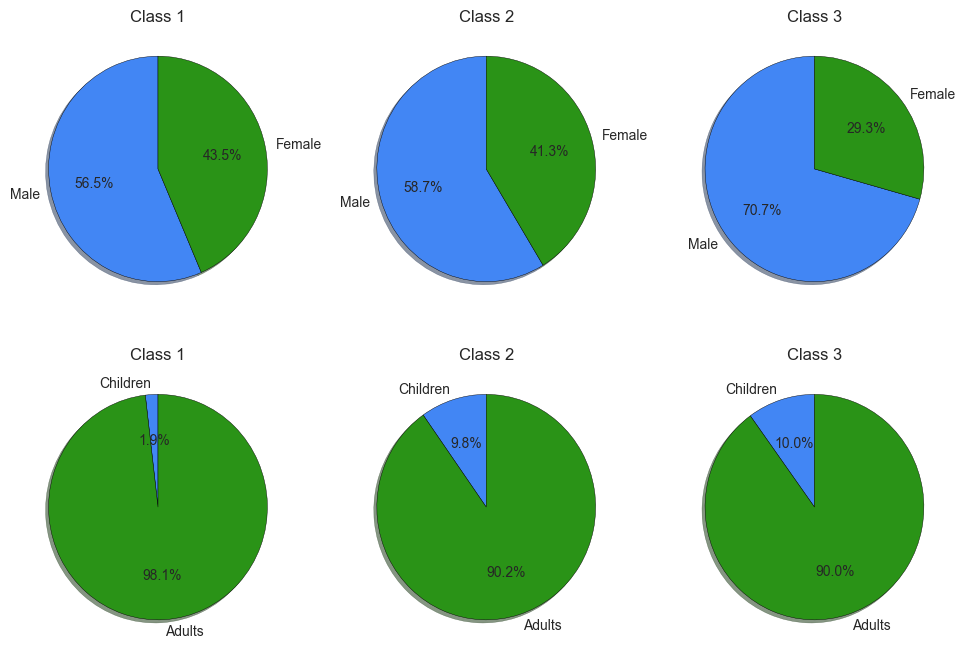

In [10]:
# group by class
grouped_by_class = titanic_data.groupby('Pclass')

plt.figure(1,figsize=(12,8))
colors = ['#4286f4', '#2a9317']
i=1
# loop through each group and determine the number of men and women / children and adults in each group, i.e. class.
for name, group in grouped_by_class:
    sex_repartition = [len(group[group.Sex=='male']), len(group[group.Sex=='female'])]
    child_repartition = [len(group[group.Adult=='child']), len(group[group.Adult=='adult'])]
    labels = ['Male', 'Female']
    plt.subplot(2,3,i)
    plt.pie(sex_repartition,labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90);
    title = 'Class ' + str(name)
    plt.title(title)
    labels = ['Children', 'Adults']
    plt.subplot(2,3,i+3)
    plt.pie(child_repartition,labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90);
    title = 'Class ' + str(name)
    plt.title(title)
    i+=1

'''
Please note that it is possible to use the plot function directly on a grouped dataframe. However, the function will be 
called twice on the first group to decide whether it can take a fast or slow code path. Therefore, the first group
will be plotted twice. Therefore it was decided to loop through the groups in order not to have the first group twice.

See the warning in:
http://pandas.pydata.org/pandas-docs/stable/groupby.html#flexible-apply
'''    

It can be seen that the 3rd class makes up 55% of the passengers. About 65% of passengers are male and only 8% children. In 1st and 2nd class men account for 57-59% of the passengers; in 3rd class however it is 71%. Only 2% of 1st class passengers are children; in 2nd and 3rd class it is approximately 10% in each class.

The next step is check the survival rate for different groups, e.g. for men, women, children etc. This is done by plotting the survival rate for different groups.

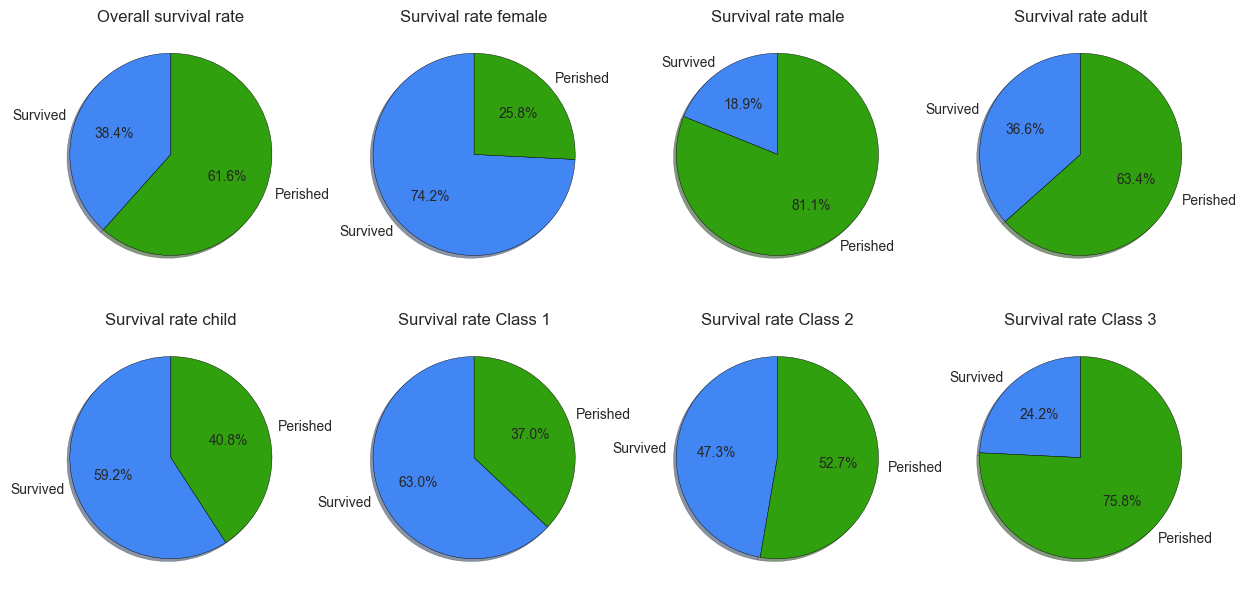

In [11]:
def pie_plot_survival_rate(data, selection):
    '''
    This function creates pie charts for survival rates. The input is the Titanic data and a selection criterium, e.g. 'male', 
    in order to plot the survival rate for the selected group.
    
    The survival rate can be calculated as the mean of 'Survived' column as it contains either 1 (=survived) or 0 (=perished).
    '''
    labels = ['Survived', 'Perished']
    colors =  ['#4286f4', '#30a00e']
    if selection is None:
        plt.pie([data.Survived.mean(),1.-data.Survived.mean()], labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
        plt.title('Overall survival rate')
    elif (selection=='male') | (selection == 'female'):
        plt.pie([data.Survived[data.Sex==selection].mean(),1.-data.Survived[data.Sex==selection].mean()], 
                labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
        title = 'Survival rate ' + selection
        plt.title(title)
    elif isinstance(selection, int):
        plt.pie([data.Survived[data.Pclass==selection].mean(),1.-data.Survived[data.Pclass==selection].mean()], 
                labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
        title = 'Survival rate Class ' + str(selection)
        plt.title(title)
    elif (selection=='adult') | (selection == 'child'):
        plt.pie([data.Survived[data.Adult==selection].mean(),1.-data.Survived[data.Adult==selection].mean()], 
                labels=labels, colors = colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
        title = 'Survival rate ' + selection
        plt.title(title)   

        
# Select criteria for pie charts. 
selection_criteria = [None, 'female', 'male', 'adult', 'child', 1, 2, 3]        

plt.figure(1, figsize=(15,15))
for i in range(len(selection_criteria)):
    plt.subplot(4,4,i+1)
    pie_plot_survival_rate(titanic_data, selection_criteria[i])


This first analysis shows that indeed women had a higher survival rate than men. Also, it can be seen that the rate of survival was higher if one held a 1st class ticket rather than a 3rd class ticket. Lastly, the survival rate below 14 years is higher than for adults.

Of course, this needs to be explored further as the parameters may be linked. For example: Was the 1st class survival rate higher because mainly women travelled first class? Or is class a direct parameter that influences the chance of survival?

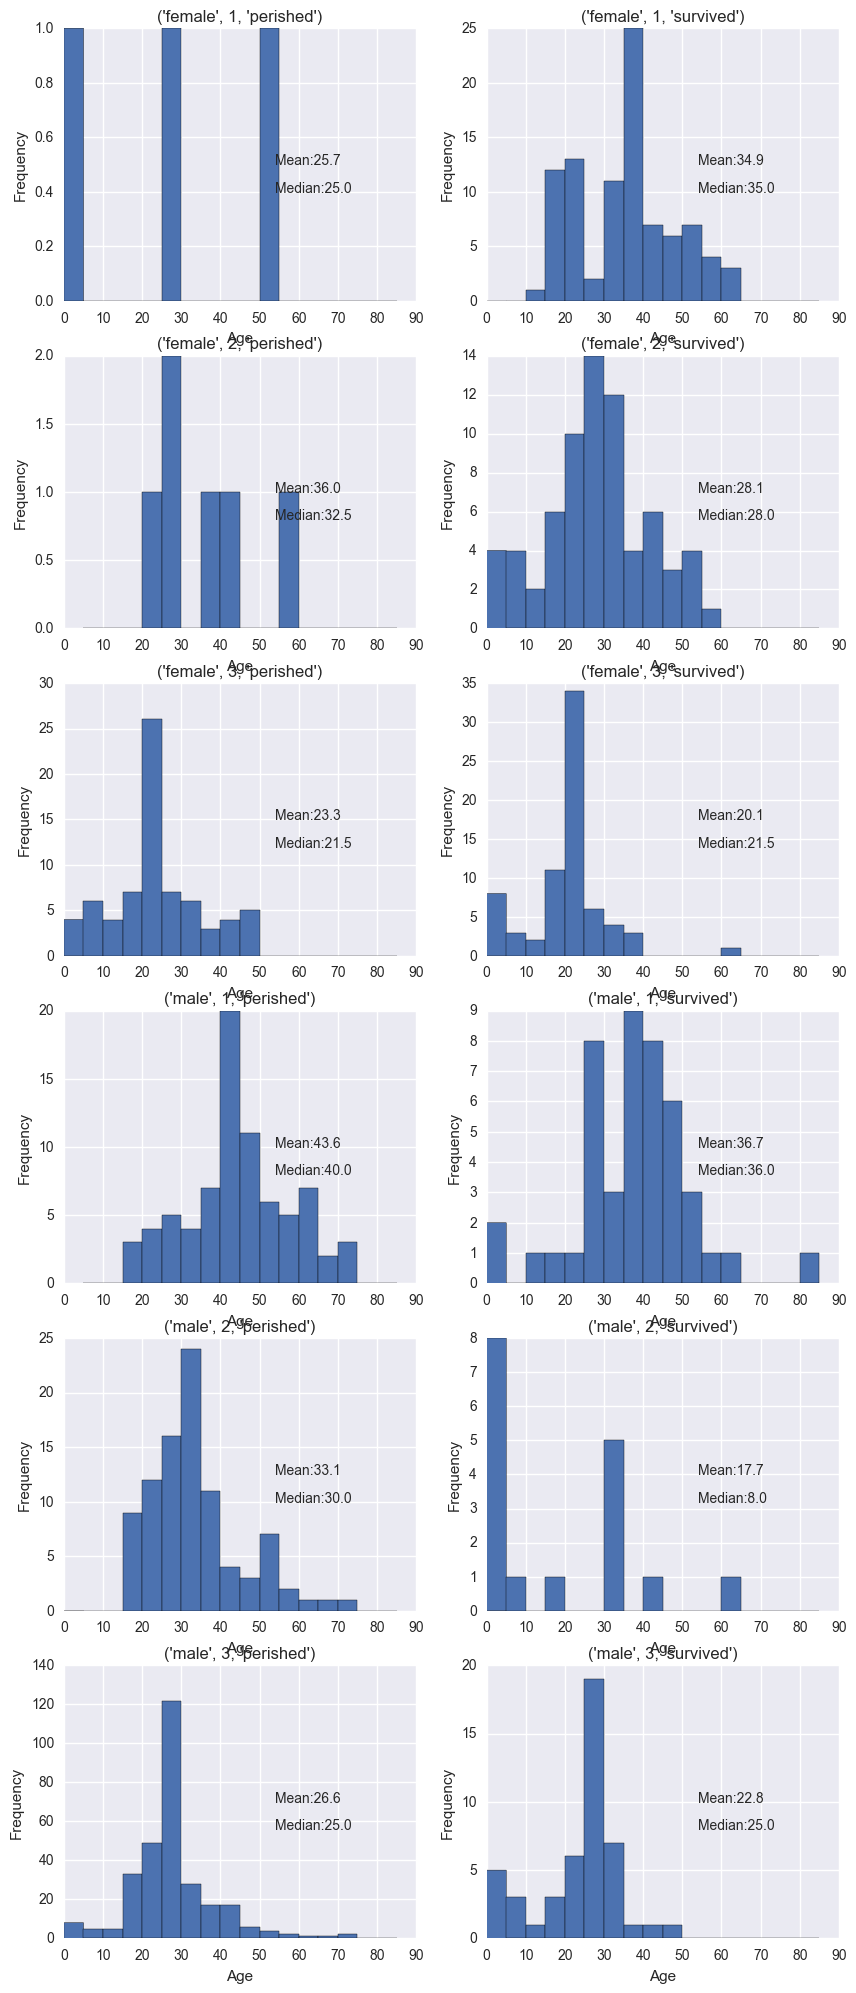

In [12]:
# Plot age distribution for survived and perished passengers for each class
# bin size is set to 5 from 0 to the maximum age contained in the dataset

grouped_data = titanic_data.groupby(['Sex', 'Pclass','Survived_class'])

i=1
plt.figure(1,figsize=(10,50))
for name, group in grouped_data:
    plt.subplot(12,2,i)
    group.Age.plot.hist(bins=range(0,int(titanic_data.Age.max()+10.),5))
    mean_age = group.Age.mean()
    median_age = group.Age.median()
    plt.annotate('Mean:'+str(np.round(mean_age,1)), xy=(.60, .5), xycoords='axes fraction')
    plt.annotate('Median:'+str(np.round(median_age,1)), xy=(.60, .4), xycoords='axes fraction')
    plt.title(name)
    plt.xlabel('Age')
    i+=1
   

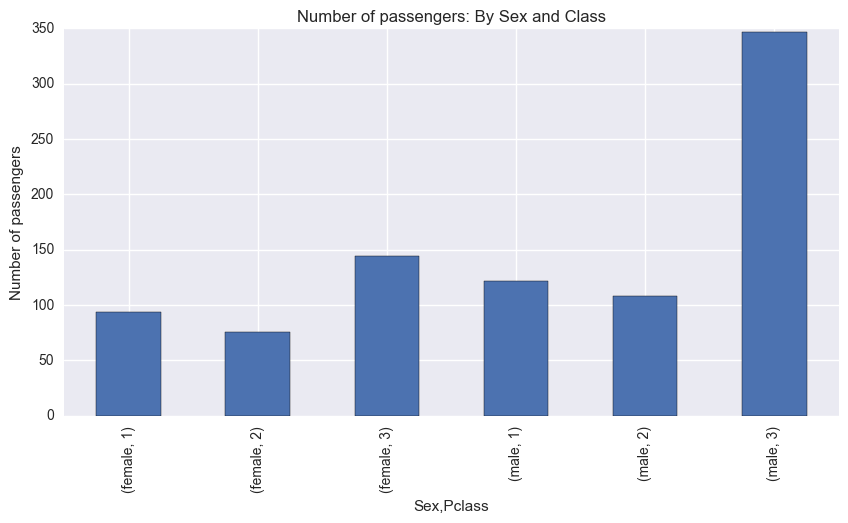

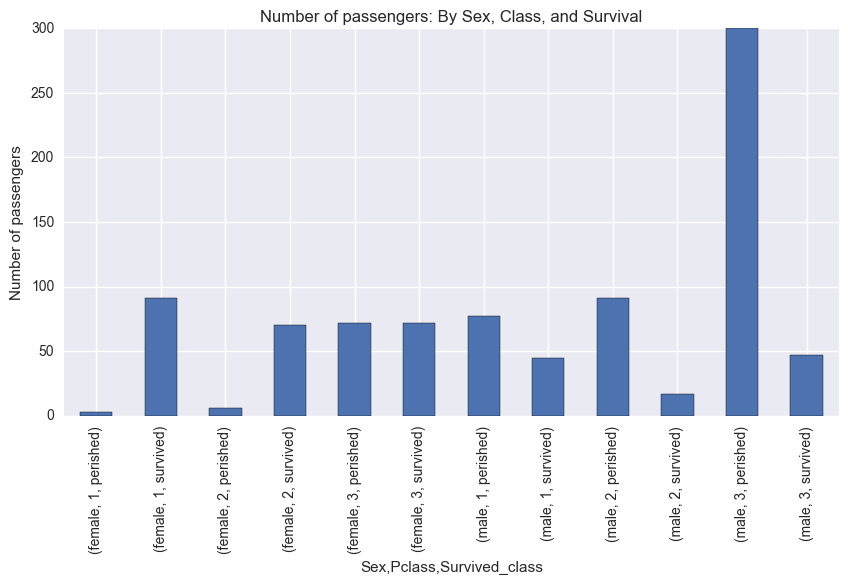

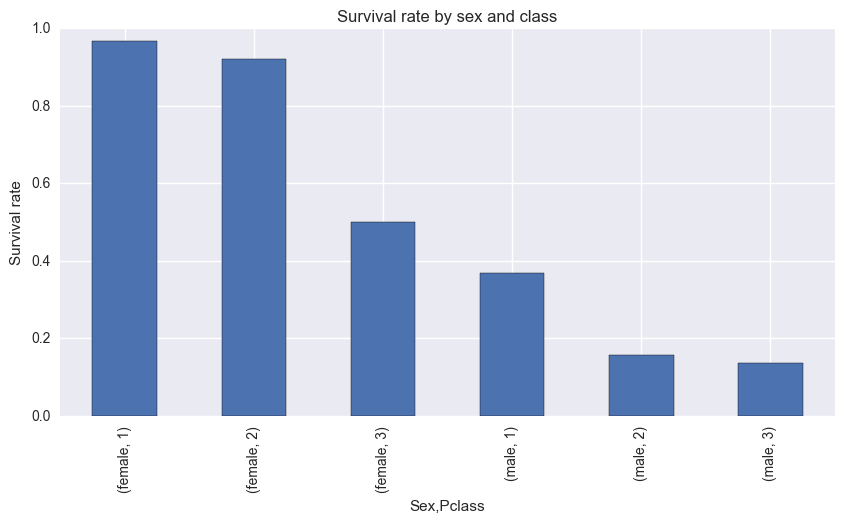

In [13]:
# Group data by sex and class. This is used to create bar plots for each group which then will be compared
# to the survival rate of this group
grouped_data_no_surv = titanic_data.groupby(['Sex', 'Pclass'])
grouped_count_no_surv = grouped_data_no_surv.PassengerId.count()
plt.figure(1,figsize=(10,5))
grouped_count_no_surv.plot.bar();
plt.title('Number of passengers: By Sex and Class')
plt.ylabel('Number of passengers')

# Data has already been grouped by class, sex, and survival in previous step. This is used to create a bar plot
# and to compare it to the data from the previous step
grouped_count = grouped_data.PassengerId.count()
plt.figure(2,figsize=(10,5))
grouped_count.plot.bar();
plt.title('Number of passengers: By Sex, Class, and Survival')
plt.ylabel('Number of passengers')

# Compute survival rate for each group and plot it
grouped_survival_mean = grouped_data_no_surv.Survived.mean()
plt.figure(3,figsize=(10,5))
grouped_survival_mean.plot.bar();
plt.ylabel('Survival rate')
plt.title('Survival rate by sex and class');




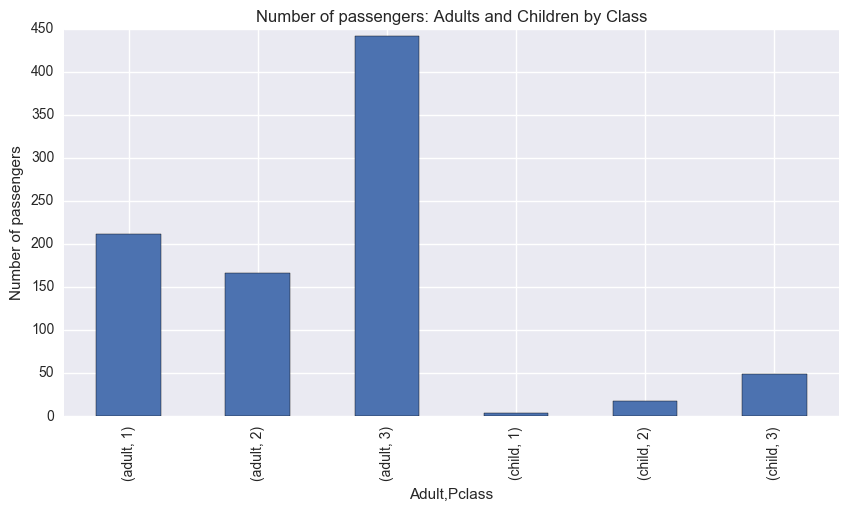

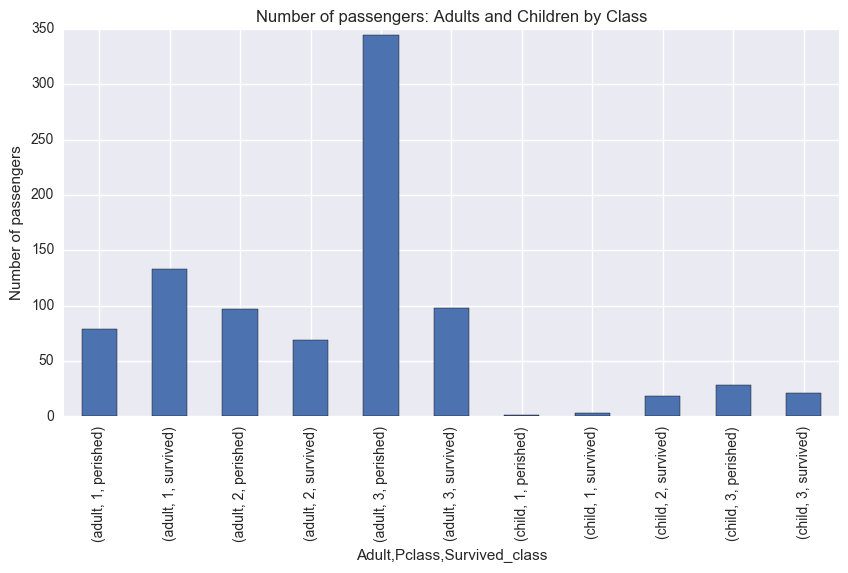

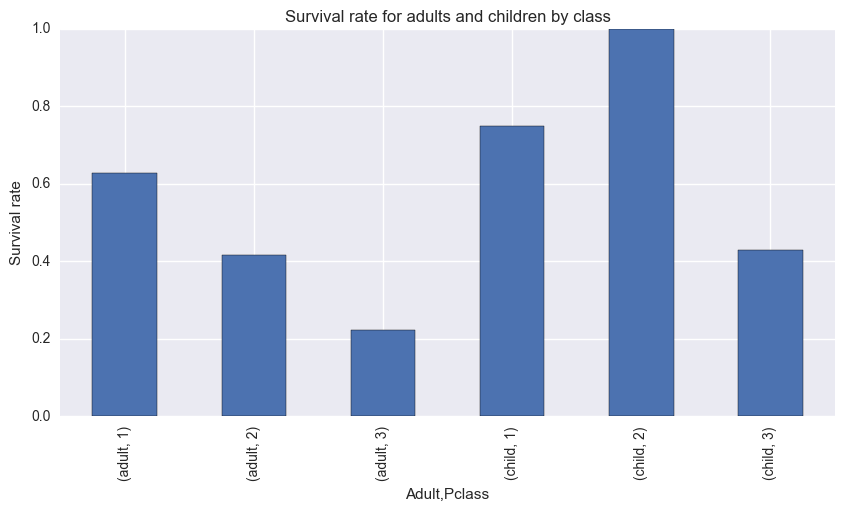

In [14]:
# Group data by adult/children and class. This is used to create bar plots for each group which then will be compared
# to the survival rate of this group
grouped_data_no_surv = titanic_data.groupby(['Adult', 'Pclass'])
grouped_count_no_surv = grouped_data_no_surv.PassengerId.count()
plt.figure(1,figsize=(10,5))
grouped_count_no_surv.plot.bar();
plt.title('Number of passengers: Adults and Children by Class')
plt.ylabel('Number of passengers')

grouped_data = titanic_data.groupby(['Adult', 'Pclass', 'Survived_class'])
grouped_count = grouped_data.PassengerId.count()
plt.figure(2,figsize=(10,5))
grouped_count.plot.bar();
plt.title('Number of passengers: Adults and Children by Class')
plt.ylabel('Number of passengers')

# Compute survival rate for each group and plot it
grouped_survival_mean = grouped_data_no_surv.Survived.mean()
plt.figure(3,figsize=(10,5))
grouped_survival_mean.plot.bar();
plt.ylabel('Survival rate')
plt.title('Survival rate for adults and children by class');

# Conclusion
The initial question was whether there are parameters that influenced the survival of the passengers of the RMS Titanic. 3rd class passengers accounted for 55% of the passengers (from the available passenger data). Also about 65% of the passengers were male. Therefore, it is not surprising to find the highest numbers of casualties coming from the group of male 3rd class passengers, knowing that 62% of all passengers perished.

Looking at the relative rate of survival showed that the survival rate among all female (across all classes) was 74% whereas 81% of all men (also across all classes) perished when the Titanic sank.

Survival rate in 1st class with 63% was the highest of all class; in 3rd class only 24% survived.

Going into more detail showed that there is a tendency of increasing survival rate with sex and class:
* Out of 94 female passengers in 1st class only 3 perished: 96.8% survival rate
* Out of 76 female passengers in 2nd class only 6 perished: 92.1% survival rate

This rate drops to 50% for 3rd class female passengers as 72 out of the 144 died.

When looking at the male passengers, a similar trend can be noticed, however, the survival rate of male 1st class passengers is significantly below the one of female passengers: 36.8% compared to 96.8%.

This drops further in 2nd (15.7%) and 3rd class (13.5%).

This trend cannot directly be seen when looking at adult and children survival rates. 75% and 100% of children in 1st and 2nd class respectively survived. In 3rd class only 42.8% of children survived. 

The number of children in 1st and 2nd class is quite low (22 in total). This sample is probably too low to detect a clear trend.

So to summarize:

There is a correlation between sex, class, and survival rate. The highest rate of survival can be found among female 1st class passengers and the lowest among male 3rd class passengers. The correlation for children is not clear; it seems that class had a higher impact on the survival rate than age. Here a statistical test could be performed to investigate this further.

# Limitations of the Analysis
According to the [RMS Titanic Wikipedia article](https://en.wikipedia.org/wiki/RMS_Titanic) there were 2,224 passengers and crew aboard the Titanic. The article states that "*The exact number of people aboard is not known, as not all of those who had booked tickets made it to the ship*".

In the dataset there are information about 891 passengers only and none about the crew. It would be interesting to see if the distribution of male/female and of the three classes of the sample at hand is representative of the population distribution. If the distribution is changed in either direction this could influence the conclusion.

It would also be interesting to take the survival rate of the crew into account. As places on life boats were limited, was priority given to passengers or did crew members take up seats that were meant for passengers. This could also skew the conclusions made above.

Lastly, one limitation is the assumption of the missing age values. The median value was chosen as this does not impact the distribution significantly (there is an impact of course, but the histograms show that the median falls in the bin of the mode of the distribution). But for the analysis of the children survival rate this may have a significant impact as the median is always greater than 14 years (the threshold chosen above to distinguish between adults and children). Therefore, if any of the persons with a missing age value were in fact a child, they were wrongly placed in the adult group.